# Tweet sentiment analysis

In [3]:
import numpy as np 
import pandas as pd 

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style("whitegrid")

# general NLP preprocessing and basic tools
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# train/test split
from sklearn.model_selection import train_test_split
# basic machine learning models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
# our evaluation metric for sentiment classification
from sklearn.metrics import fbeta_score

import warnings
warnings.simplefilter("ignore")


In [4]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eurecom-aml-2021-challenge-3/sample_submission.csv
/kaggle/input/eurecom-aml-2021-challenge-3/train.csv
/kaggle/input/eurecom-aml-2021-challenge-3/test.csv


## Loading the data

In [5]:
train_df = pd.read_csv('/kaggle/input/eurecom-aml-2021-challenge-3/train.csv')
test_df = pd.read_csv('/kaggle/input/eurecom-aml-2021-challenge-3/test.csv')

We start off by converting the labels to numbers. This is a requirement for the submission and numerical inputs are generally more compatible with machine learning libraries.

In [6]:
target_conversion = {
    'neutral': 0,
    'positive': 1,
    'negative': -1
}

In [7]:

train_df['target'] = train_df['sentiment'].map(target_conversion)

## Quick data inspection

In [8]:
len(train_df)+len(test_df)

27480

Let's see the distribution of the sentiment :


In [ ]:
counter = train_df["sentiment"].value_counts()
distribution = [counter[0],counter[1],counter[2]]
labels=['neutral','positive','negative']
fig1, ax1 = plt.subplots()
ax1.pie(distribution, labels=labels,autopct='%1.1f%%',startangle=90)
plt.show()

The classes seem to be balanced. Let's observe the size of the tweets :
It seems that working with 'selected_text' instead of 'text' greatly improves the accuracy of our analysis. We'll therefore work with those tweets for the moment.

In [ ]:
train_df['selected_text'].apply(lambda x : len(x.split()) ).value_counts().sort_index().plot.bar()
plt.xlabel("Number of words")
plt.title('Number of words repartition train set')
plt.show()

test_df['selected_text'].apply(lambda x : len(x.split()) ).value_counts().sort_index().plot.bar()
plt.xlabel("Number of words")
plt.title('Number of words repartition test set')
plt.show()

Let's see if the number of words is correlated with the sentiment :

In [ ]:
grouped = train_df[['text','sentiment']].groupby(['sentiment'])
dfs = [(grouped.get_group(x))['text'].apply(lambda x : len(x.split()) ).value_counts().sort_index().rename(x) for x in grouped.groups]
pd.concat(dfs,axis = 1).plot.bar()
plt.xlabel("Number of words")
plt.title('Number of words repartition selected_text per sentiment train set')
plt.show()

It doesn't seem to be any clear difference in the repartition. We therefore think that we can't use the number of word as some kind of feature. Let's get some info on the dataframes to check for missing values or anything like this.

In [ ]:
print(train_df.info())
print(test_df.info())

## Data preprocessing

In [9]:
# we create a validation dataset from the training data
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=0)

**Let's clean the data**
There is no messing data (no Nan ...) so we can proceed to the next step of our pre-processing,

* Remove none alphabetic characters
* Make the word lower case
* Remove the stop words
* Stemming(process of finding the base word )
* Spell correction

In [35]:
pip install autocorrect

     |████████████████████████████████| 622 kB 416 kB/s eta 0:00:01
  Created wheel for autocorrect: filename=autocorrect-2.5.0-py3-none-any.whl size=621854 sha256=4bf439196cd41187bdebc47cde6f5618326222070619280b8dc4ecae9897c1df
  Stored in directory: /root/.cache/pip/wheels/3d/8e/bd/f6fd900a056a031bf710a00bca338d86f43b83f0c25ab5242f
Successfully built autocorrect
Note: you may need to restart the kernel to use updated packages.


In [40]:
import re
import nltk



nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

nltk.download('punkt')
from nltk.tokenize import word_tokenize as wt 


from autocorrect import Speller
spell1 = Speller()

def cleaner(x):
    
    # remove non alphabatic characters
    x = re.sub('[^A-Za-z]', ' ', x)
    
    # make words lowercase (to reduce size of vocabulary)
    x = x.lower()
    
    # tokenising
    tokenized_x = wt(x)
    
    processed = []
    for word in tokenized_x:
        if word not in set(stopwords.words('english')):
            processed.append(spell1(stemmer.stem(word)))
    cleaned_text = " ".join(processed)
    return x

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
train_df['selected_text'] = train_df['selected_text'].apply(lambda x : cleaner(x))

In [42]:
val_df['selected_text'] = val_df['selected_text'].apply(lambda x : cleaner(x))

Now that the data is cleaned and therefore more exploitable we can start to process it via 2 methods. The first one will be by using "Bag-of-Word" and the other one using "Bert".

## Method I : Bag-of-Words

In [43]:
count_vect = CountVectorizer()

#TF-IDF take another approach which is believe that high frequency 
# may not able to provide much information gain.
#In another word, rare words contribute more weights to the model.
norm_count_vec = TfidfVectorizer()


In [44]:
# here we are obtaining the vocabulary from the training data minus validation data
# you may want to change this to the full training data for the final submission
X_train_counts = count_vect.fit_transform(list(train_df['selected_text'].values))
X_val_counts = count_vect.transform(list(val_df['selected_text'].values))
X_test_counts = count_vect.transform(list(test_df['selected_text'].values))


X_train_counts_norm = norm_count_vec.fit_transform(list(train_df['selected_text'].values))
X_val_counts_norm = norm_count_vec.transform(list(val_df['selected_text'].values))
X_test_counts_norm = norm_count_vec.transform(list(test_df['selected_text'].values))

***Training a simple classifier***

In [45]:
%%time
clf = MultinomialNB().fit(X_train_counts, train_df['target'])

CPU times: user 7.78 ms, sys: 999 µs, total: 8.77 ms
Wall time: 7.88 ms


In [46]:
val_predictions_nb = clf.predict(X_val_counts)

accuracy = (val_predictions_nb == val_df['target'].values).mean()
print('The accuracy of our multinomial Naive Bayes classifier is: {:.2f}%'.format(accuracy*100))
fbeta = fbeta_score(val_df['target'].values, val_predictions_nb, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

The accuracy of our multinomial Naive Bayes classifier is: 78.98%
The fbeta score is: 0.7831592311491203


Training with the normalized data :

In [47]:
clf2 = MultinomialNB().fit(X_train_counts_norm, train_df['target'])

In [48]:
val_predictions_nb_norm = clf2.predict(X_val_counts_norm)

accuracy = (val_predictions_nb_norm == val_df['target'].values).mean()
print('The accuracy of our multinomial Naive Bayes classifier is: {:.2f}%'.format(accuracy*100))
fbeta = fbeta_score(val_df['target'].values, val_predictions_nb_norm, average='macro', beta=1.0)
print('The fbeta score is:', fbeta)

The accuracy of our multinomial Naive Bayes classifier is: 78.13%
The fbeta score is: 0.7737609401534923


## Method II : Using Bert
We are going to use the bert transformer model with pytorch

In [10]:
pip install bert-for-tf2


     |████████████████████████████████| 41 kB 104 kB/s eta 0:00:01
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30536 sha256=ff44bd0f199841d8175a4532b5cf788b992519983dbc1c9292ce330c8c574a85
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19471 sha256=e4cb9954a0b0c3ec7bc149f54438232f67f89f0729dc6581442785b8bf0c1c09
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7910 sha256=953a2ba7897734985986fa666b1aab03d67d63eb5647da95428f8e5f99853306
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params
Note: you may need to restart the kernel to use updated packages.


First we decided to only take the data that we find usefull ie the selected_text ; 

In [11]:
traindf = train_df[['selected_text','target']]
valdf = val_df[['selected_text','target']]

In [12]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import torch 

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")


from tqdm import tqdm


In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [14]:
MAX_LEN = 50

We need to define a dataset that's compatible with pyTorch :

In [15]:
class TweetDataset(Dataset):
    
    def __init__(self, tweets, targets, tokenizer, max_len):
            self.tweets = tweets
            self.targets = targets
            self.tokenizer = tokenizer
            self.max_len = max_len
    
    
    def __len__(self):
            return len(self.tweets)
        
        
    def __getitem__(self, item):
            tweet = str(self.tweets[item])
            target = self.targets[item]
            encoding = self.tokenizer.encode_plus(
              tweet,
              add_special_tokens=True,
              max_length=self.max_len,
              return_token_type_ids=False,
              pad_to_max_length=True,
              return_attention_mask=True,
              return_tensors='pt',
              truncation=True
            )
            return {
              'tweet_text': tweet,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten(),
              'targets': torch.tensor(target, dtype=torch.long)
            }

Next we need to create the dataLoaders :

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    
    ds = TweetDataset(
            tweets=df.selected_text.to_numpy(),
            targets=df.target.to_numpy(),
            tokenizer=tokenizer,
            max_len=max_len
          )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
      )

The model used does not support the class "-1" so a conversion is needed to process the data, afterward another conversion will be made to come back to the right labels.

In [17]:
target_conversion = {
    0: 0,
    1: 1,
    -1: 2
}

traindf['target'] = traindf['target'].map(target_conversion)
valdf['target'] = valdf['target'].map(target_conversion)

In [18]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(traindf, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(valdf, tokenizer, MAX_LEN, BATCH_SIZE)

Now that all the building blocks are prepared we can define the actual model :

In [19]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [20]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
            super(SentimentClassifier, self).__init__()
            self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
            self.drop = nn.Dropout(p=0.3)
            self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        
        returned = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        pooled_output = returned["pooler_output"]
        output = self.drop(pooled_output)
        return self.out(output)
        
        

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output.

Let's move it to the GPU for the training. We tried on the CPU the the processing time is ridiculously high.

In [21]:
model = SentimentClassifier(3)
model = model.to(device)

In [22]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)



For the parameter we decided to stick to the ones given bu the BERT authors. Their recommendations for fine-tuning are :

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

The next function is the helper one that actually trains the model. (One epoch function)

In [23]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    fbeta =[]
    correct_predictions = 0
    
    for d in tqdm(data_loader):
            
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            fbeta.append(fbeta_score(targets.cpu().numpy(), preds.cpu().numpy(), average='macro', beta=1.0))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses), np.mean(np.array(fbeta))

And then the ultimate function is made to evaluate our model on the val data.

In [24]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    fbeta_val = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            fbeta_val.append(fbeta_score(targets.cpu().numpy(), preds.cpu().numpy(), average='macro', beta=1.0))
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses), np.mean(np.array(fbeta_val))

Using those two, we can write our training loop. We’ll also store the training history:

In [25]:
%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss, train_fbeta = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(traindf)
  )
    print(f'Train loss {train_loss} accuracy {train_acc} fbeta {train_fbeta}')
    val_acc, val_loss, val_fbeta = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(valdf)
      )
    print(f'Val   loss {val_loss} accuracy {val_acc} fbeta {val_fbeta}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_fbeta'].append(train_fbeta)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

  0%|          | 0/1392 [00:00<?, ?it/s]

Epoch 1/5
----------


100%|██████████| 1392/1392 [03:05<00:00,  7.49it/s]

Train loss 0.8842834949536228 accuracy 0.5868451792613891 fbeta 0.5113627400531423


Val   loss 0.6054138106684531 accuracy 0.7991107518189167 fbeta 0.7722816548613229



  0%|          | 0/1392 [00:00<?, ?it/s]

Epoch 2/5
----------


100%|██████████| 1392/1392 [03:04<00:00,  7.53it/s]

Train loss 0.4355590562389671 accuracy 0.8492227513702938 fbeta 0.832580817675716


Val   loss 0.35255545994206783 accuracy 0.8771220695230396 fbeta 0.8616459291001735



  0%|          | 0/1392 [00:00<?, ?it/s]

Epoch 3/5
----------


100%|██████████| 1392/1392 [03:04<00:00,  7.55it/s]

Train loss 0.2739965508895359 accuracy 0.9094258244226794 fbeta 0.9004387522952051


Val   loss 0.3823677878646601 accuracy 0.8811641067097817 fbeta 0.8730180637922748



  0%|          | 0/1392 [00:00<?, ?it/s]

Epoch 4/5
----------


100%|██████████| 1392/1392 [03:03<00:00,  7.59it/s]

Train loss 0.19375497836304492 accuracy 0.9445592595920567 fbeta 0.9383351207319661


Val   loss 0.4685774652332428 accuracy 0.8831851253031527 fbeta 0.8701727138146966



  0%|          | 0/1392 [00:00<?, ?it/s]

Epoch 5/5
----------


100%|██████████| 1392/1392 [03:01<00:00,  7.65it/s]

Train loss 0.14081775342450803 accuracy 0.9654955521610207 fbeta 0.960896659325843


Val   loss 0.47630128515133213 accuracy 0.8936944219886822 fbeta 0.8827756307035418

CPU times: user 15min 24s, sys: 11.1 s, total: 15min 35s
Wall time: 15min 53s


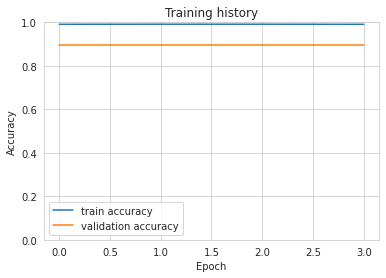

In [44]:
# Let's plot the results 

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

We observe that the val_accuracy doesn't evolve that much during the training. We think it means that we have to do more pre-processing work in order to really improve our current results.

## Results Analysis

We tried using the 'text' instead of 'selected_text' but the processing time is way higher for far worst results. Therefore all thos results were achieved by using 'selected_text'.

Let's analyse the results of our methods on the validation set.


**Method 1 : Bag-of-Words :**

In [49]:
predicted = pd.DataFrame()
predicted['textID'] = val_df['textID']
predicted['sentiment_pred'] = val_predictions_nb_norm
predicted['sentiment'] = val_df['sentiment']

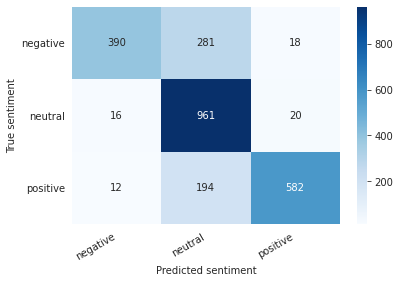

In [50]:
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
    
cm = confusion_matrix(val_df['target'], predicted['sentiment_pred'])
class_names = ['negative', 'neutral', 'positive']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

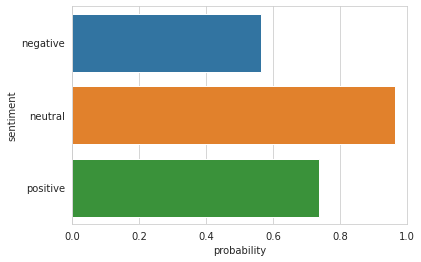

In [51]:
confidence = []
for i,x in enumerate(cm):
    confidence.append(x[i]/x.sum())

pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': confidence
})


sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

It seems that the neutral sentiment is better treated than the other two. Let's see if the misclassified ones reveal something.

In [52]:
target_conversion = {
     0 : "neutral",
     1 : "positive",
     -1: "negative"
}

MisClassified_Bag = pd.DataFrame()
MisClassified_Bag = val_df[['selected_text','sentiment']]
MisClassified_Bag["predicted"] = predicted['sentiment_pred'].map(target_conversion)
MisClassified_Bag = MisClassified_Bag[MisClassified_Bag['sentiment'] != MisClassified_Bag['predicted']]

In [53]:
MisClassified_Bag.head(10)

,selected_text,sentiment,predicted
15592,google wave looks cool,positive,neutral
7451,the right side of my earphones just sto...,negative,neutral
8208,enjoying the great sunshine from indoors i...,neutral,positive
6815,leaving,negative,neutral
7229,going crazy the pain is unbearable i gotta...,negative,neutral
21645,this class is really long,negative,neutral
15136,was pleased with star trek,positive,neutral
13840,we didnt see you though,negative,neutral
16140,bad times for everyone whywhywhy do we have t...,negative,neutral
2923,picnic,positive,neutral


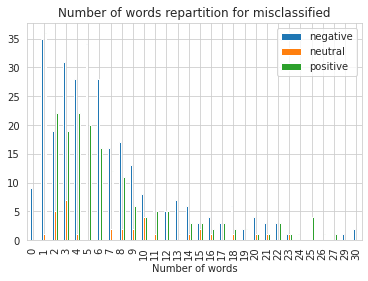

In [54]:
#Let's see their length

grouped = MisClassified_Bag[['selected_text','sentiment']].groupby(['sentiment'])
dfs = [(grouped.get_group(x))['selected_text'].apply(lambda x : len(x.split()) ).value_counts().sort_index().rename(x) for x in grouped.groups]
pd.concat(dfs,axis = 1).plot.bar()
plt.xlabel("Number of words")
plt.title('Number of words repartition for misclassified')
plt.show()

Again the shorter words seems harder to classify.

**Method 2 : Bert**

In [26]:
def tokenize(tweet):
    return tokenizer.encode_plus(
                                  tweet,
                                  max_length=MAX_LEN,
                                  add_special_tokens=True,
                                  return_token_type_ids=False,
                                  pad_to_max_length=True,
                                  return_attention_mask=True,
                                  return_tensors='pt',
                                  truncation=True
                                )

valdf = val_df['selected_text'].apply(lambda x : tokenize(x))
predicted = []


for x in valdf :
    input_ids = x['input_ids'].to(device)
    attention_mask = x['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    
    predicted.append(prediction.item())
    
target_conversion = {
     0 : 0,
     1 : 1,
     2: -1
}

prediction = pd.DataFrame()
prediction['textID'] = val_df['textID']
prediction['sentiment'] = predicted
prediction['sentiment'] = prediction['sentiment'].map(target_conversion)

First the confusion matrix will show us the repartition of the right and false prediction over the 3 sentiments

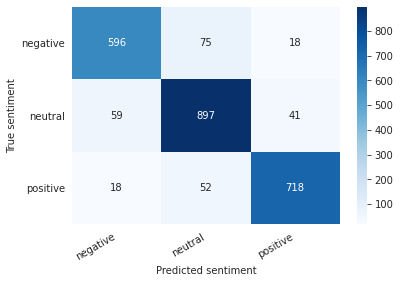

In [27]:
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
    
cm = confusion_matrix(val_df['target'], prediction['sentiment'])
class_names = ['negative', 'neutral', 'positive']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Now we can look at the confidence of each sentiment of our model:

In [28]:
confidence = []
for i,x in enumerate(cm):
    confidence.append(x[i]/x.sum())

pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': confidence
})

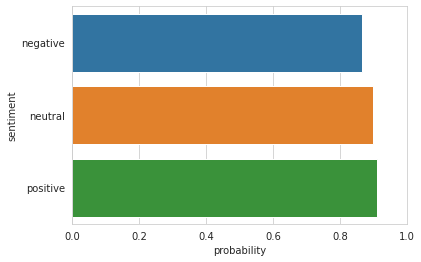

In [29]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

There doesn't seem to be a sentiment that does better than the other ones.

Let's focus on the one that aren't well classified. We think that classifying the tweets on the 3 sentiments classes can include mistakes even when done by a human. The frontier between neutral and positive or negative can be blurry and therefore the model (as a human) can't really distinguish them.

In [30]:
  target_conversion = {
     0 : "neutral",
     1 : "positive",
     -1: "negative"
}

MisClassified = pd.DataFrame()
MisClassified = val_df[['selected_text','sentiment']]
MisClassified["predicted"] = prediction['sentiment'].map(target_conversion)
MisClassified = MisClassified[MisClassified['sentiment'] != MisClassified['predicted']]

In [31]:
MisClassified.head(5)

,selected_text,sentiment,predicted
6008,She didn`t make the challenge,neutral,negative
7451,****...the right side of my earphones just sto...,negative,neutral
2491,Ahh its so gloomy out I`m pretty sure I just ...,neutral,negative
6815,leaving,negative,neutral
13840,we didnt see you though,negative,neutral


As expected a major part of the tweets that are wrongly classified are even complex to classify for a human being. The given sentiment are not obvious choices in all the cases. The question we could ask is : is the human or our model that is really wrong ?

Let's see the correlation with the length

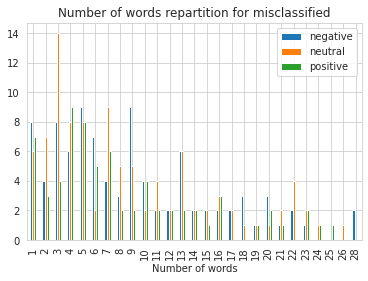

In [32]:
#Let's see their length

grouped = MisClassified[['selected_text','sentiment']].groupby(['sentiment'])
dfs = [(grouped.get_group(x))['selected_text'].apply(lambda x : len(x.split()) ).value_counts().sort_index().rename(x) for x in grouped.groups]
pd.concat(dfs,axis = 1).plot.bar()
plt.xlabel("Number of words")
plt.title('Number of words repartition for misclassified')
plt.show()

It seems that shorter tweets are more complex to classify.

We also observed that the results of Bert were worst when using our 'cleaning' helper function. It's is probably because 'selected_text' includes short text and cleaning it means removing some parts so loosing information in some cases.

Comparaison : Are the same one misclassified ?

## Submitting

Submission for the method 2

In [33]:
#Getting the test data ready for the BERT method :
def tokenize(tweet):
    return tokenizer.encode_plus(
                                  tweet,
                                  max_length=MAX_LEN,
                                  add_special_tokens=True,
                                  return_token_type_ids=False,
                                  pad_to_max_length=True,
                                  return_attention_mask=True,
                                  return_tensors='pt',
                                  truncation=True
                                )

#test_df['selected_text'] = test_df['selected_text'].apply(lambda x : cleaner(x))
testdf = test_df['selected_text'].apply(lambda x : tokenize(x))
predicted = []

model.load_state_dict(torch.load('best_model_state.bin'))
for x in testdf :
    input_ids = x['input_ids'].to(device)
    attention_mask = x['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    
    predicted.append(prediction.item())

In [34]:
#We need to inverse the target labels becasue we used only positive ones for the model to work without any issue

target_conversion = {
     0 : 0,
     1 : 1,
     2: -1
}


submission_df = pd.DataFrame()
submission_df['textID'] = test_df['textID']
submission_df['sentiment'] = predicted
submission_df['sentiment'] = submission_df['sentiment'].map(target_conversion)
submission_df.to_csv('Submission4.csv', index=False)

Submission for the method 1

In [ ]:
# Creating a submission

X_train_counts = count_vect.fit_transform(list(train_df['selected_text'].values) + list(val_df['selected_text'].values))
X_test_counts = count_vect.transform(list(test_df['selected_text'].values))

clf = MultinomialNB().fit(X_train_counts, np.hstack([train_df['target'].values, val_df['target'].values]))
test_predictions_nb = clf.predict(X_test_counts)

submission_df = pd.DataFrame()
submission_df['textID'] = test_df['textID']
submission_df['sentiment'] = test_predictions_nb
submission_df.to_csv('Submission2.csv', index=False)

### Feature extraction:
- Can we make our Bag-of-Words representation more compact or richer? There are many things you could try to implement. Here are some buzzwords: tokenization, stop words removal, lemmatization, n-gram extraction, ...
- A useful Python library to address these issues is: NLTK (https://www.nltk.org/)
- The sklearn CountVectorizer we used can be combined with NLTK preprocessing:
https://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes
- Is there also a dense (as opposed to sparse) representation of documents (tweets in our case)? Buzzwords: word2vec, LDA, LSI
- A useful Python library for this purpose (with pretrained models) is: gensim https://radimrehurek.com/gensim/
- The state-of-the-art: ... are neural network language models, so-called Transformers. There are pretrained models available. If you feel comfortable with neural networks, fine-tuning and GPUs, have a look here: https://huggingface.co/transformers/

### Model evaluation:

Make sure to select potential model hyperparameters using cross-validation or similar. Our evaluation metric of choice is the F1-score:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score

We choose beta=1 and average=macro